In [1]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from torch.nn.functional import mse_loss, l1_loss
from movqgan import get_movqgan_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/miniconda3/envs/lavit/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_images(batch, return_image=False):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    if return_image:
        return Image.fromarray(reshaped.numpy())
    display(Image.fromarray(reshaped.numpy()))


def prepare_image(img):
    """ Transform and normalize PIL Image to tensor. """
    transform = T.Compose([
            T.RandomResizedCrop(512, scale=(1., 1.), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
        ])
    pil_image = transform(img)
    arr = np.array(pil_image.convert("RGB"))
    arr = arr.astype(np.float32) / 127.5 - 1
    return torch.from_numpy(np.transpose(arr, [2, 0, 1]))

In [3]:
device = "mps"
model = get_movqgan_model('67M', pretrained=True, device=device)

img = prepare_image(Image.open("image.jpg")).to(device).unsqueeze(0)

Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


MSE: 0.00427
L1: 0.03868


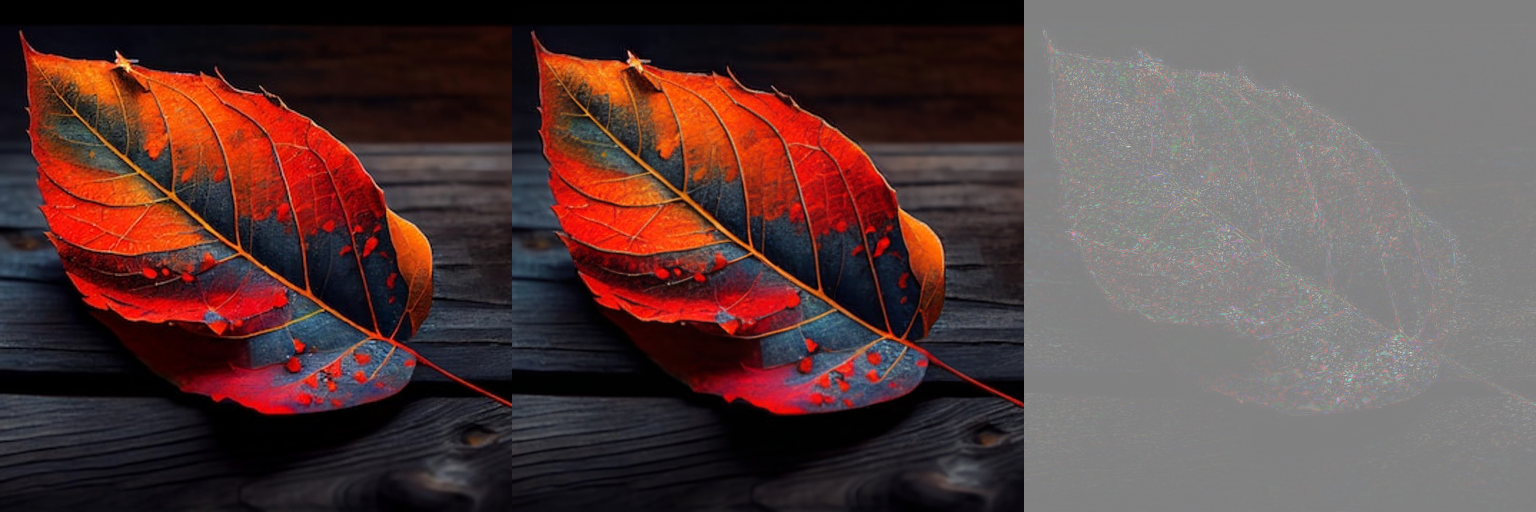

In [4]:
with torch.no_grad():
    # quant = embeddings(codebook_indices)
    quant, loss, (perplexity, min_encodings, codebook_indices, sorted_indices) = model.encode(img)
    out = model.decode(quant)

mse = np.round(mse_loss(img, out).item(), 5)
l1 = np.round(l1_loss(img, out).item(), 5)

print("MSE:", mse)
print("L1:", l1)
show_images(torch.cat((img, out, torch.abs(img - out)), dim=0))

### Experiment with distance-based code selection

0.29296875
[0.4881889820098877, 0.53125, 0.40625, 0.5390625, 0.4453125, 0.5, 0.4765625, 0.4296875, 0.4765625, 0.4375, 0.4296875, 0.484375, 0.484375, 0.3984375, 0.4609375, 0.4609375, 0.46875, 0.53125, 0.5703125, 0.4140625, 0.4921875, 0.4921875, 0.4765625, 0.484375, 0.3828125, 0.5078125, 0.421875, 0.5, 0.4765625, 0.453125, 0.515625, 0.5234375]


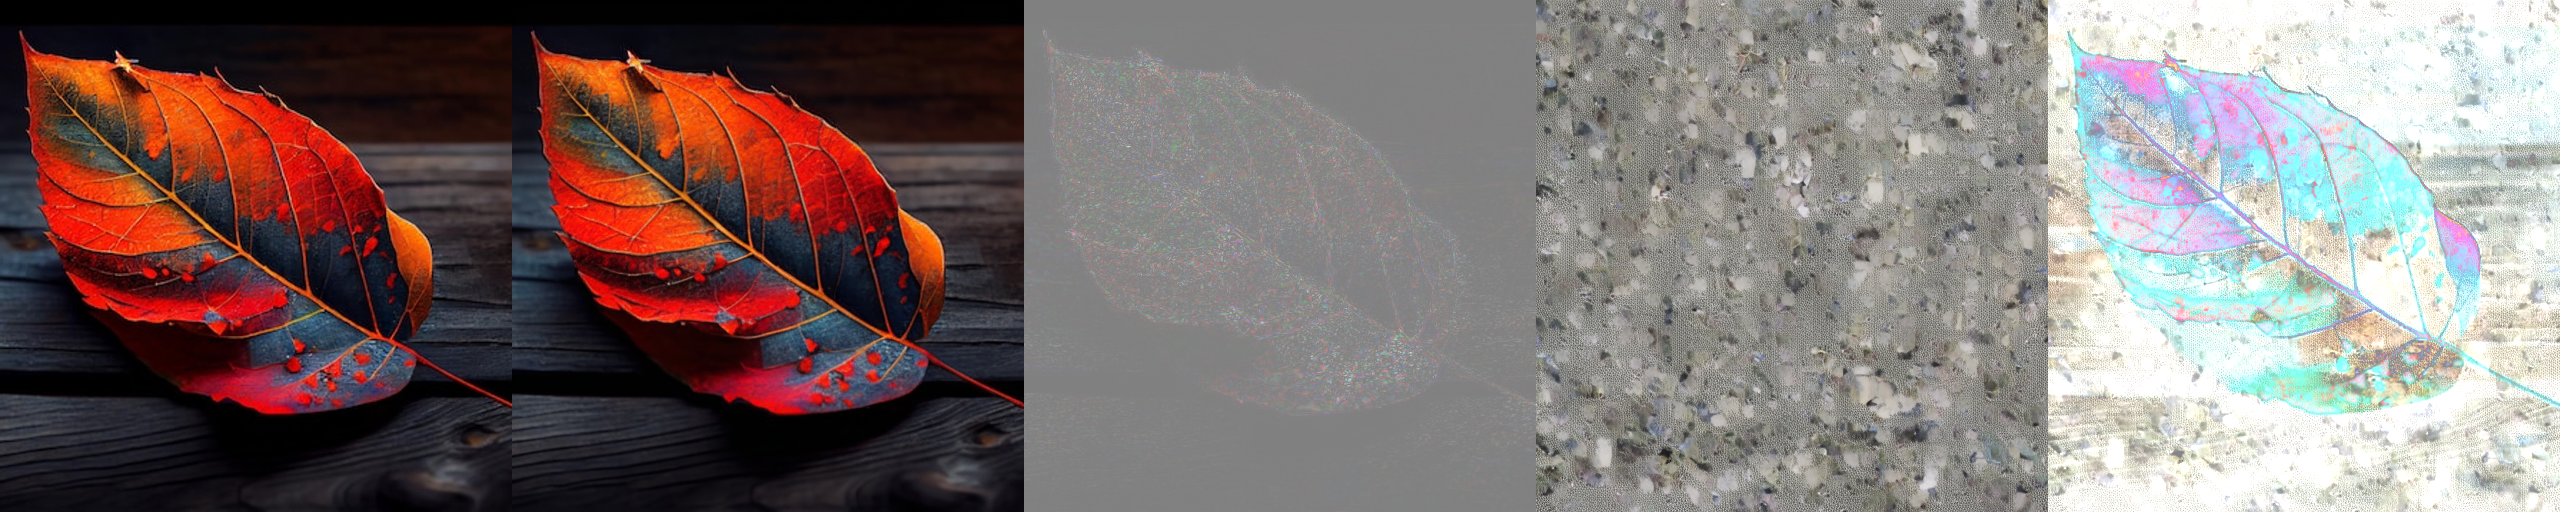

In [5]:
import watermarking

codes = codebook_indices

payload = 0b1010101010101010101010101010
n_payload_bits = 32
watermarked_indices = watermarking.redgreen_embed_payload_sorted(codes, sorted_indices=sorted_indices, payload=payload, n_payload_bits=n_payload_bits)

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked_indices.view(1, 64, 64))
    quant, loss, (perplexity, min_encodings, reencoded_indices, reencoded_sorted_indices) = model.encode(watermarked_image)

print((watermarked_indices == reencoded_indices).cpu().numpy().mean())

detection_info = watermarking.detect_payload_sorted(reencoded_indices, reencoded_sorted_indices, n_payload_bits=n_payload_bits, threshold=0.45)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:032b}")
print(detection_info["average_bits"])

show_images(torch.cat((img, out, torch.abs(img - out), watermarked_image, torch.abs(img - watermarked_image)), dim=0))

In [6]:
from sklearn.cluster import KMeans


embeddings = model.quantize.embedding.weight
embeddings = embeddings.detach().cpu().numpy()

k = 1000
rate = 0.2

def get_cluster_indices(clustering_object):
    clusters = {i: [] for i in range(clustering_object.n_clusters)}
    for idx, label in enumerate(clustering_object.labels_):
        clusters[label].append(idx)
    clusters = {k: torch.tensor(v, device=device) for k, v in clusters.items()}
    return clusters


kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(embeddings)
clusters = get_cluster_indices(kmeans)

In [7]:
import watermarking


codes = codebook_indices

# watermarked = watermarking.replace_codes_within_clusters(codes, clusters=clusters, rate=0.25)

# with torch.no_grad():
#     watermarked_image = model.decode_code(watermarked.view(1, 64, 64))
#     quant, loss, (perplexity, min_encodings, codebook_indices) = model.encode(watermarked_image)

# print((watermarked == codebook_indices).cpu().numpy().mean())

# show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

In [8]:
payload = 0b1010101010101010101010101010
n_payload_bits = 32
watermarked_indices = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=n_payload_bits)

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked_indices.view(1, 64, 64))
    quant, loss, (perplexity, min_encodings, reencoded_indices) = model.encode(watermarked_image)

print((watermarked_indices == reencoded_indices).cpu().numpy().mean())

detection_info = watermarking.detect_payload(reencoded_indices, clusters=clusters, n_payload_bits=n_payload_bits, threshold=0.45)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:032b}")
print(detection_info["average_bits"])

show_images(torch.cat((img, out, torch.abs(img - out), watermarked_image, torch.abs(img - watermarked_image)), dim=0))

KeyboardInterrupt: 

In [ ]:
watermarked_indices = watermarking.redgreen_zero_bit(codes, clusters=clusters)

# with torch.no_grad():
#     watermarked_image = model.decode_code(watermarked_indices.view(1, 64, 64))
#     quant, loss, (perplexity, min_encodings, reencoded_indices) = model.encode(watermarked_image)

# print((watermarked_indices == reencoded_indices).cpu().numpy().mean())

detection_info = watermarking.detect_zero_bit(watermarked_indices, clusters=clusters, threshold=0.7)
print(detection_info["watermarked"])
print(detection_info["average_bits"])
# print(detection_info["detections"])

# show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

watermark 1 11796
watermark 2 6770
watermark 3 14098
watermark 4 4738
watermark 5 8064
watermark 6 7083
watermark 7 11936
watermark 8 8780
watermark 9 1287
watermark 10 7083
watermark 11 11936
watermark 12 8780
watermark 13 1287
watermark 14 7083
watermark 15 11936
watermark 16 8780
watermark 17 1287
watermark 18 7083
watermark 19 11936
watermark 20 8780
watermark 21 1287
watermark 22 7083
watermark 23 11936
watermark 24 8780
watermark 25 1287
watermark 26 7083
watermark 27 11936
watermark 28 8780
watermark 29 1287
watermark 30 7083
watermark 31 11936
watermark 32 8780
watermark 33 1287
watermark 34 7083
watermark 35 11936
watermark 36 8780
watermark 37 1287
watermark 38 7083
watermark 39 11936
watermark 40 8780
watermark 41 1287
watermark 42 7083
watermark 43 11936
watermark 44 8780
watermark 45 1287
watermark 46 7083
watermark 47 11936
watermark 48 8780
watermark 49 1287
watermark 50 7083
watermark 51 11936
watermark 52 8780
watermark 53 1287
watermark 54 7083
watermark 55 11936
wate

KeyboardInterrupt: 

In [ ]:
detection_info = watermarking.detect_zero_bit(watermarked_indices, clusters=clusters, threshold=0.7)
print(detection_info["watermarked"])
print(detection_info["average_bits"])

detect 1 11796
detect 2 6770
detect 3 14098
detect 4 4738
detect 5 8064
detect 6 7083
detect 7 11936
detect 8 8780
detect 9 1287
detect 10 7083
detect 11 11936
detect 12 8780
detect 13 1287
detect 14 7083
detect 15 11936
detect 16 8780
detect 17 1287
detect 18 7083
detect 19 11936
detect 20 8780
detect 21 1287
detect 22 7083
detect 23 11936
detect 24 8780
detect 25 1287
detect 26 7083
detect 27 11936
detect 28 8780
detect 29 1287
detect 30 7083
detect 31 11936
detect 32 8780
detect 33 1287
detect 34 7083
detect 35 11936
detect 36 8780
detect 37 1287
detect 38 7083
detect 39 11936
detect 40 8780
detect 41 1287
detect 42 7083
detect 43 11936
detect 44 8780
detect 45 1287
detect 46 7083
detect 47 11936
detect 48 8780
detect 49 1287
detect 50 7083
detect 51 11936
detect 52 8780
detect 53 1287
detect 54 7083
detect 55 11936
detect 56 8780
detect 57 1287
detect 58 7083
detect 59 11936
detect 60 8780
detect 61 1287
detect 62 7083
detect 63 8412
detect 64 6770
detect 65 6770
detect 66 14098
de

In [10]:
detection_info = watermarking.detect_payload(codes, clusters=clusters, n_payload_bits=32)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:032b}")
print(detection_info["average_bits"])

00010111110111001011111110111110
[0.4724409580230713, 0.484375, 0.453125, 0.546875, 0.5, 0.5625, 0.6015625, 0.5703125, 0.609375, 0.546875, 0.4765625, 0.5703125, 0.53125, 0.5546875, 0.46875, 0.4609375, 0.546875, 0.4765625, 0.53125, 0.5234375, 0.5234375, 0.5078125, 0.5625, 0.609375, 0.53125, 0.4375, 0.515625, 0.5234375, 0.5546875, 0.578125, 0.546875, 0.484375]


### Ablate clustering

#### K-means with other k

In [ ]:
k = 5000

clustering_object = KMeans(n_clusters=k, random_state=42)
clustering_object.fit(embeddings)
clusters = get_cluster_indices(clustering_object)

watermarked = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=64)

detection_info = watermarking.detect_payload(watermarked, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

mse = np.round(mse_loss(img, watermarked_image).item(), 5)
l1 = np.round(l1_loss(img, watermarked_image).item(), 5)

print("MSE:", mse)
print("L1:", l1)

0000000000000000000000000000000000000000000000000000000001010101
[0.0, 0.0, 0.0, 0.0, 0.078125, 0.109375, 0.109375, 0.21875, 0.21875, 0.1875, 0.234375, 0.21875, 0.28125, 0.21875, 0.21875, 0.265625, 0.21875, 0.28125, 0.359375, 0.3125, 0.234375, 0.234375, 0.34375, 0.25, 0.3125, 0.390625, 0.34375, 0.359375, 0.40625, 0.359375, 0.46875, 0.40625, 0.28125, 0.296875, 0.296875, 0.28125, 0.265625, 0.3125, 0.34375, 0.296875, 0.296875, 0.21875, 0.234375, 0.21875, 0.203125, 0.28125, 0.34375, 0.25, 0.171875, 0.265625, 0.25, 0.171875, 0.09375, 0.15625, 0.109375, 0.109375, 0.09375, 1.0, 0.15625, 1.0, 0.21875, 1.0, 0.15625, 1.0]
MSE: 0.0056
L1: 0.04762


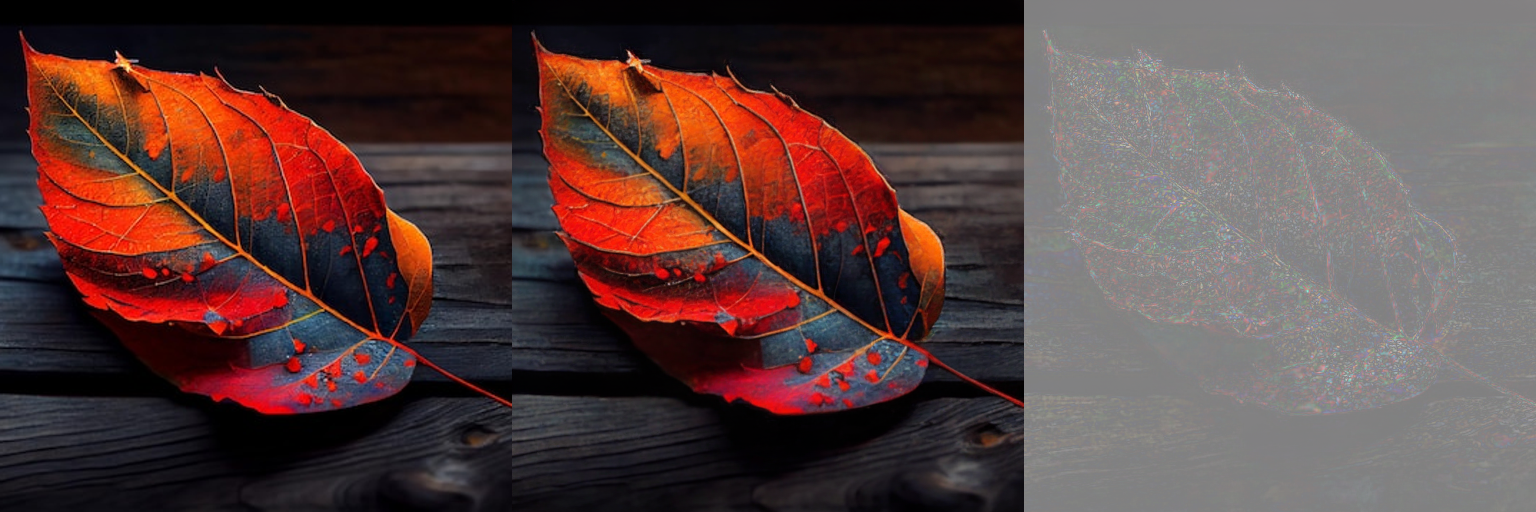

In [ ]:
show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

0011111111111111111111111111111111111111111111111111111111111111
[0.0476190485060215, 0.0625, 1.0, 0.984375, 1.0, 0.984375, 0.953125, 0.984375, 0.9375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.96875, 0.96875, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.9375, 0.984375, 0.984375, 1.0, 0.984375, 0.953125, 0.96875, 1.0, 0.953125, 0.90625, 0.921875, 0.953125, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
MSE: 0.00427
L1: 0.03868


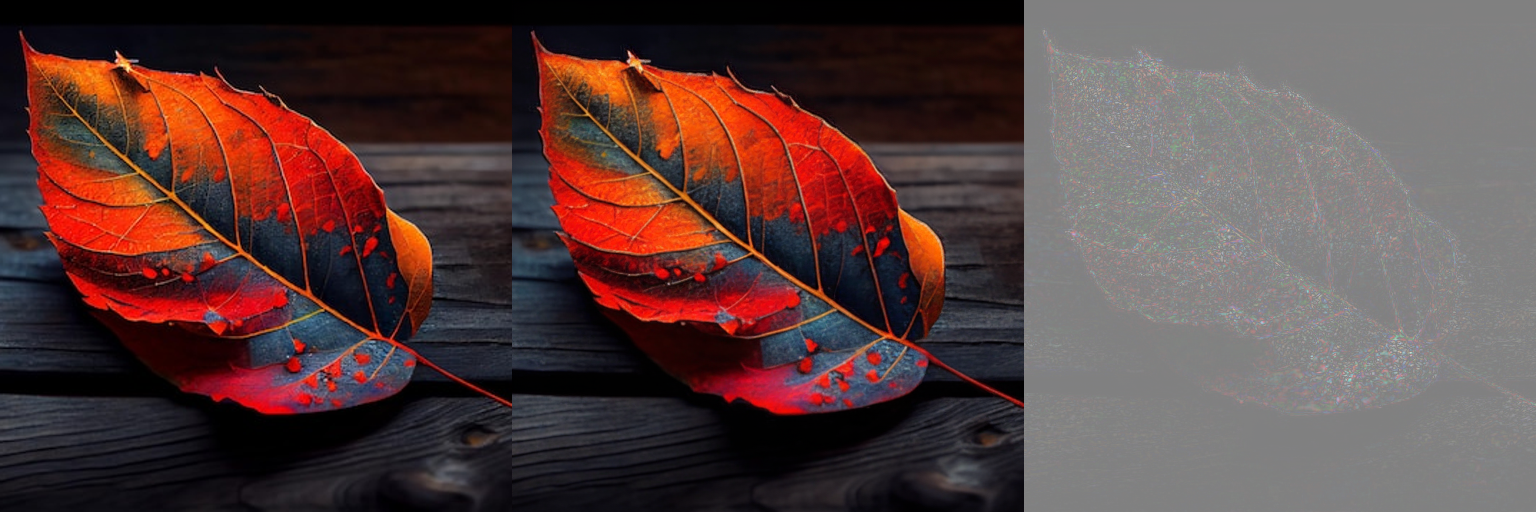

In [13]:
k = 8000

clustering_object = KMeans(n_clusters=k, random_state=42)
clustering_object.fit(embeddings)
clusters = get_cluster_indices(clustering_object)

watermarked = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=64)

detection_info = watermarking.detect_payload(watermarked, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

mse = np.round(mse_loss(img, watermarked_image).item(), 5)
l1 = np.round(l1_loss(img, watermarked_image).item(), 5)

print("MSE:", mse)
print("L1:", l1)
show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

#### Other clustering algorithms

In [14]:
from sklearn.cluster import DBSCAN


eps = 1e-4
min_samples = 10


def get_cluster_indices(clustering_object):
    # Extract unique cluster labels, excluding noise (-1 label)
    unique_labels = set(clustering_object.labels_)
    unique_labels.discard(-1)  # Remove noise label
    
    clusters = {label: [] for label in unique_labels}
    for idx, label in enumerate(clustering_object.labels_):
        if label != -1:  # Ignore noise points
            clusters[label].append(idx)
    clusters = {k: torch.tensor(v, device=device) for k, v in clusters.items()}
    return clusters


clustering_object = DBSCAN(eps=eps, min_samples=min_samples)
clustering_object.fit(embeddings)
clusters = get_cluster_indices(clustering_object)

print(clusters.keys())

dict_keys([np.int64(0)])


In [15]:
watermarked = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=64)

detection_info = watermarking.detect_payload(watermarked, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

mse = np.round(mse_loss(img, watermarked_image).item(), 5)
l1 = np.round(l1_loss(img, watermarked_image).item(), 5)

print("MSE:", mse)
print("L1:", l1)
show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

KeyError: -1

In [10]:
embeddings.shape

(16384, 4)